## Import 및 Device 설정
- 라이브러리 임포트
- GPU 사용 여부 체크

In [1]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 이미지 전처리
- 관측 이미지 리사이즈
- RGB 이미지 그레이스케일로 변경

In [2]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

## 환경 클래스
- **초기화**
    - **no_operation:** 초기 reset 후 no-op 액션을 몇 번 수행하여 초기 상태를 다양하게 함
    - **skip_frames:** 한 번의 step에서 여러 프레임을 스킵하여 계산량을 줄이고 더 추상화된 동작을 하게 함
    - **stack_frames:** 마지막 n개 프레임을 쌓아(스택) 관측으로 사용한다. 이렇게 하면 단일 이미지만으로는 파악하기 어려운 속도/이동 정보 등을 시간적 연속성으로 얻을 수 있음
- **reset:** 환경 리셋 후 no-op 수행, 관측 이미지 전처리 후 초기 스택 상태 생성
- **step:** skip_frames 동안 같은 액션을 반복, reward 합산, 최종 관측 이미지 stack에 추가

In [3]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

### Noisy Linear 레이어

In [4]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))
        
        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.sigma_init * mu_range)
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.sigma_init * mu_range)

    def reset_noise(self):
        epsilon_in = torch.randn(self.in_features, device=device)
        epsilon_out = torch.randn(self.out_features, device=device)
        epsilon_out = epsilon_out.sign().mul_(epsilon_out.abs().sqrt_())
        epsilon_in = epsilon_in.sign().mul_(epsilon_in.abs().sqrt_())
        self.weight_epsilon.copy_(epsilon_out.unsqueeze(1) * epsilon_in.unsqueeze(0))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            # 평가 시 노이즈를 제거하거나 고정할 수 있음
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(x, weight, bias)

## DuelingCNN모델
- 기존 DQN보다 더 안정적인 Q값 추정

In [5]:
class ImprovedDuelingCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self._n_features = 64 * 7 * 7  
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),  # 16->32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),            # 32->64
            nn.ReLU(),
            # BatchNorm 추가
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.fc = nn.Sequential(
            nn.Linear(self._n_features, 512),  # 256 -> 512로 확대
            nn.ReLU(),
        )

        # NoisyLinear로 대체
        self.value_head = NoisyLinear(512, 1)
        self.adv_head = NoisyLinear(512, out_features=out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        value = self.value_head(x)
        adv = self.adv_head(x)
        q = value + adv - adv.mean(dim=1, keepdim=True)
        return q
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

## PrioritizedReplayMemory 클래스
- **Transition:** 강화학습 에이전트의 경험을 저장하기 위한 데이터 구조
- **init:** capacity 변수를 사용해 리플레이 메모리에 저장할 최대 경험수 정의
- **push:** Transition을 리플레이 메모리에 추가
- **sample:** batch_size만큼 Transition 랜덤 샘플링

In [6]:
class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = deque([], maxlen=capacity)
        self.priorities = deque([], maxlen=capacity)

    def push(self, *args):
        max_priority = max(self.priorities, default=1.0)
        self.memory.append(Transition(*args))
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        # TD 오차 기반 우선순위 계산
        priorities = np.array(self.priorities, dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]

        # 중요도 샘플링 가중치
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        batch = Transition(*zip(*samples))
        return batch, indices, torch.tensor(weights, device=device, dtype=torch.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)

## DQN 클래스
- **주요 변수:**
    - **action_space:** 환경의 액션 공간
    - **network:** 주 네트트워크로 Q-network
    - **target_netwrork:** 타겟 Q-network로 일정 주기마다 복사해서 학습
    - **optimizer:** AdamW 옵티마이저
    - **memory:** 리플레이 메모리
    - **eps_threshold:** epsilon-greedy 정책에서 탐색 비율
- **select_action:** e-greedy 정책을 사용해 액션 선택
- **train:** 리플레이 메모리에서 mini-batch를 샘플링해 Q-network 업데이트
- **copy_weights:** 주 네트워크 가중치를 타겟 네트워크에 복사
- **get_loss:** 현재까지 기록된 손실 값 반환
- **save_model:** 타겟 네트워크의 가중치를 파일로 저장
- **load_model:** 저장된 파일로부터 네트워크 가중치를 불러오기

In [7]:
# 기존 ReplayMemory를 PrioritizedReplayMemory로 대체
# Double DQN 로직 추가 (next_state_values 계산 부분)
class DQN:
    def __init__(self, action_space, batch_size=256, gamma=0.99, eps_start=1.0, eps_end=0.05, eps_decay=2000, lr=0.001, alpha=0.6, beta=0.4):
        self._n_observation = 4
        # CarRacing-v2 (continuous=False) -> Discrete action space
        self._n_actions = action_space.n
        self._action_space = action_space
        self._batch_size = batch_size
        self._gamma = gamma
        self._eps_start = eps_start
        self._eps_end = eps_end
        self._eps_decay = eps_decay
        self._lr = lr
        self._total_steps = 0
        self._evaluate_loss = []
        self.alpha = alpha
        self.beta = beta  # 중요도 샘플링 가중치 파라미터

        self.network = ImprovedDuelingCNN(self._n_observation, self._n_actions).to(device)
        self.target_network = ImprovedDuelingCNN(self._n_observation, self._n_actions).to(device)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = optim.AdamW(self.network.parameters(), lr=self._lr, amsgrad=True)

        # Prioritized Replay Memory 사용
        self.memory = PrioritizedReplayMemory(10000, alpha=self.alpha)

    def select_action(self, state, evaluation_phase=False):
        sample = random.random()
        eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
        self._total_steps += 1

        if evaluation_phase:
            with torch.no_grad():
                return self.target_network(state).max(1)[1].view(1, 1)
        elif sample > eps_threshold:
            with torch.no_grad():
                return self.network(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self._n_actions)]], device=device, dtype=torch.long)

    def train(self):
        if len(self.memory) < self._batch_size:
            return

        # Prioritized Replay에서 샘플링
        batch, indices, weights = self.memory.sample(self._batch_size, beta=self.beta)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # 현재 상태 Q값
        state_action_values = self.network(state_batch).gather(1, action_batch)

        # Double DQN 로직: 다음 상태 액션을 현재 네트워크에서 선택
        with torch.no_grad():
            next_actions = self.network(non_final_next_states).max(1)[1].unsqueeze(1)
            # 선택한 액션의 Q값을 타겟 네트워크에서 평가
            next_state_values = torch.zeros(self._batch_size, device=device)
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).gather(1, next_actions).squeeze()

        expected_state_action_values = (next_state_values * self._gamma) + reward_batch

        # 손실 계산 (중요도 샘플링 가중치 적용)
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1), reduction='none')
        loss = (loss * weights.unsqueeze(1)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
        self.optimizer.step()

        # TD 오차 기반 우선순위 업데이트
        td_errors = (state_action_values - expected_state_action_values.unsqueeze(1)).abs().detach().cpu().numpy().flatten()
        self.memory.update_priorities(indices, td_errors)

        self._evaluate_loss.append(loss.item())

    def copy_weights(self):
        self.target_network.load_state_dict(self.network.state_dict())

    def get_loss(self):
        return self._evaluate_loss

    def save_model(self, i):
        torch.save(self.target_network.state_dict(), f'./dueling_dqn_v6/model_weights_{i}.pth')

    def load_model(self, i):
        self.target_network.load_state_dict(torch.load(f'./dueling_dqn_v6/model_weights_{i}.pth', map_location=device))

## 학습 코드

In [8]:
# 초기 변수 설정
rewards_per_episode = []
episode_duration = []
average_episode_loss = []

episodes = 1000
C = 5

# 환경 및 에이전트 초기화
env = gym.make('CarRacing-v2', lap_complete_percent=0.95, continuous=False)
env = CarEnvironment(env)
action_space = env.action_space
agent = DQN(action_space)

for episode in range(1, episodes + 1):
    if episode % 10 == 0:
        print(f"{episode} episodes done")

    env = gym.make('CarRacing-v2', continuous=False)
    env = CarEnvironment(env)
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_total_reward = 0

    for t in count():
        action = agent.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        episode_total_reward += reward.item()
        done = terminated or truncated

        if terminated:
            next_state = None
            print("Finished the lap successfully!")
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        agent.memory.push(state, action, next_state, reward)
        state = next_state

        agent.train()

        if done:
            if len(agent.memory) >= 128:
                episode_duration.append(t + 1)
                rewards_per_episode.append(episode_total_reward)
                ll = agent.get_loss()
                average_episode_loss.append(sum(ll) / len(ll))
            break

        if episode % 100 == 0:
            agent.save_model(episode)
            with open('./dueling_dqn_v6/statistics.pkl', 'wb') as f:
                pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

    if episode % C == 0:
        agent.copy_weights()

agent.save_model(episodes)
with open('./dueling_dqn_v6/statistics.pkl', 'wb') as f:
    pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

10 episodes done
Finished the lap successfully!
Finished the lap successfully!
20 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
30 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
40 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
50 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap

## 통계 시각화 함수
- 데이터 시각화
- 이미지 저장
- 분석

In [8]:
def plot_statistics(x, y, title, x_axis, y_axis):
    plt.plot(x, y)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_")}.png')  # 공백 대신 밑줄 사용
    plt.show()
     

## 평가 코드

/tmp/ipykernel_2658332/4070252038.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_network.load_state_dict(torch.load(f'./dueling_dqn_v6/model_weights_{i}.pt

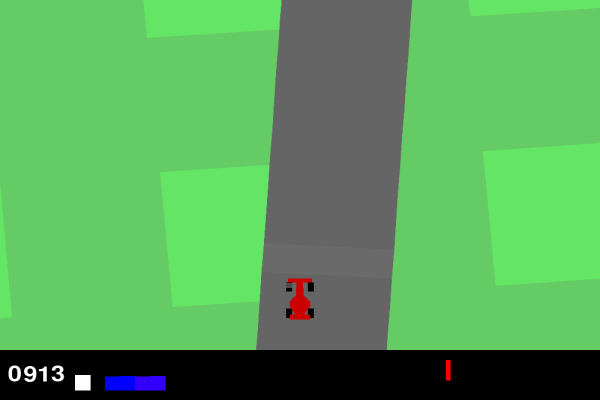

909.8739926739847


In [19]:
#환경 생성 및 불러오기
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = DQN(n_actions)
agent.load_model(300)

#변수 초기화
frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

#렌더링을 위한 함수 및 디스플레이 핸들
from PIL import Image as PILImage
def render2img(_img): return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    #현재 스텝의 프레임 이미지를 받아 업데이트 및 저장
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    #상태, 액션 선택 및 변환
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True) #평가 모드
    discrete_action = a.item() % 5
    #환경 스텝 적용 및 결과 관측
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    #상태 및 보상 업데이트
    s = s_prime
    ret += r
    done = terminated or truncated
    #에피소드 종료 시 처리
    if terminated:
      print(terminated)

#총 점수 업데이트 및 출력
scores += ret
print(scores)


def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    #비디오 파일 이름 설정
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP80')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    #프레임을 비디오에 추가
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

## 통계 데이터 시각화 및 평가 결과 비디오에 저장

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


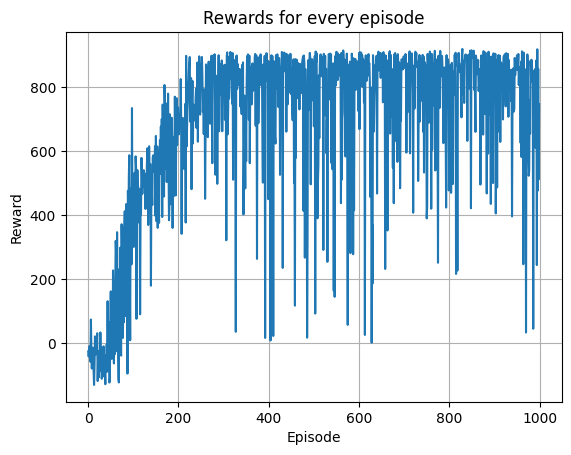

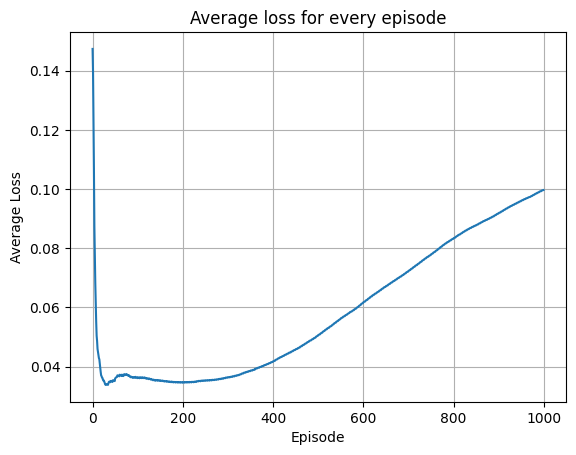

In [19]:
#비디오 애니메이션 생성
animate(frames, 'dueling_dqn_v6_1000.webm')

#통계 데이터 로드
with open('./dueling_dqn_v6/statistics.pkl', 'rb') as f:
    data_tuple = pickle.load(f)

episode_duration, rewards_per_episode, average_episode_loss = data_tuple

x = [k for k in range(1000)]

# rewards_per_episode = [tensor.cpu() if tensor.is_cuda else tensor for tensor in rewards_per_episode]

#통계 데이터 시각화
plot_statistics(x, rewards_per_episode, "Rewards for every episode", "Episode", "Reward")
plot_statistics(x, average_episode_loss, "Average loss for every episode", "Episode", "Average Loss")